# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'))

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'))

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 11314
Testing Samples: 7532


In [4]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
newsgroups_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
newsgroups_train['data'][1000]

"Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?\nSorry, don't know the version of the driver (no indication in the menus) but it's a recently\ndelivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered\nif anyone else had seen this.\n\npost or email"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [7]:
# Instantiate vectorizer
vect = TfidfVectorizer(min_df=5)

# Transform the training data
X_train = vect.fit_transform(newsgroups_train['data'])
print(X_train.shape)

(11314, 18101)


In [8]:
params_1 = {
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate classifier
clf = RandomForestClassifier()

# GridSearch
gs1 = GridSearchCV(clf, params_1, cv=5, n_jobs=-1, verbose=1)
gs1.fit(X_train, newsgroups_train['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [9]:
gs1.best_score_

0.6428323551946451

In [10]:
gs1.best_params_

{'min_samples_leaf': 2}

In [11]:
test_sample = vect.transform(["The new york yankees are the best team in the region."])
test_sample.shape

(1, 18101)

In [12]:
gs1.predict(test_sample)[0]

9

In [13]:
newsgroups_train['target_names'][9]

'rec.sport.baseball'

### GridSearch with BOTH the Vectoizer & Classifier

In [14]:
from sklearn.pipeline import Pipeline

# 1. Create a pipeline with a vectorize and a classifier
# 2. Use Grid Search to optimize the entire pipeline
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

params_2 = {
    'vect__stop_words': (None, 'english'), 
    'vect__min_df': (2, 5),
    'clf__max_depth': (10, None)
}

gs2 = GridSearchCV(pipe, params_2, cv=5, n_jobs=-1, verbose=1)
gs2.fit(newsgroups_train['data'], newsgroups_train['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [15]:
gs2.best_score_

0.6607746264533867

In [16]:
gs2.best_params_

{'clf__max_depth': None, 'vect__min_df': 2, 'vect__stop_words': 'english'}

In [17]:
pred = gs2.predict(["The new york yankees are the best team in the region."])
pred

array([9])

In [18]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [19]:
# Download spacy model
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [20]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.DataFrame({
    'content': newsgroups_train['data'],
    'target': newsgroups_train['target'],
    'target_names': [newsgroups_train['target_names'][i] for i in newsgroups_train['target']]
})
print(df.shape)

(11314, 3)


In [22]:
pd.set_option('display.max_colwidth', 0)
df.sample(3)

,content,target,target_names
4932,"I was looking at the amps diagram for Sony 1090/2090 receivers, and I\nwas amazed to find a difference between the US and Canadian model\non the capacitor(s) that hangs off the output to the speakers:\n\n ------\/\/\----- to speaker (identical both models\nfrom amp ---------------|\n(idnetical both models) >\n < 10 \n >\n |\n ----- \n | | \n 0.022 --- --- Canadian model only!\n US model --- --- 0.047 \n and world-wide | |\n model only. | --- Candian model only!\n | --- 0.047\n | |\n ----------- gound\n\nThe board itself is also identical, with room for all three caps. The\nUS/Can versions is clearly indicated in both places.\n\nHow does that make sense? 0.047/2 is 0.0235, essentially 0.022 for caps\n(there are just standard caps, no special W/type/precision).",12,sci.electronics
11173,"H E L P !\n\nI have a problem in which I'm getting increasing frustrated every day...\n\nSome background about my PC:\n\n- American Megatrend BIOS (clone 386 SX) with 32M of RAM\n- config.sys file:\n\n\tdevice=c:\dos\himem.sys\n\tdos=high,umb\n\tdevice=c:\windows\emm386.exe noems\n\tfiles=30\n\tbuffers=30\n\tstack=9,256\n\n- autoexec.bat file is using smartdrv.exe +c\n- CMOS set up is running 0 wait state on read and write cache ram.\n\nThe problem: APPLICATION ERROR from WIN31\n\nI started off with a newly installed WIN31 and then installed EXCEL.\nRun excel, no problem. A permanent swap file of size 18K was in place\nfor windows.\n\nOk, I then proceed to install Norton Desktop\nfor Windows version 2.0. No problem with the installation. I also\nallow NDW to alter my autoexec.bat(with the nav running on c:).\nThe problem came when I try to (bring up excel or if excel is running\nand right in the middle of it - like click a selection with the mouse)\nfrom the desktop.\nFirst of all, I always get the application error screen followed by\nanother application error screen with various different messages. The\nfollowing are some of them:\n\n- Stack fault, by TC1024.DRV at address 0001:XXXX where XXXX is some\n number. (TC1024.DRV is the VGA driver provided by the manufacture)\n- General protection fault, by ndw.exe at the same address\n- Segment load failure, by ndw.exe at same address\n\nSome how, the address flagged was always 0001:something. What is address\n0001:XXXX means? \n\nI have absolutely on idea what this mean. I tried commented out the\nTSR programs from autoexec.bat, no help.\n\nIs it something to do with the emm386 setup which is not telling\nWIN31 what it suppose to know. Looks like the application is crossing\nmemory boundary when it is being loaded or while it is running.\n\nPlease reply if you have any idea or suggestion. I'm willing to try\nanything.\n",3,comp.sys.ibm.pc.hardware
619,"\n The OpenLook window manager source is available on the MIT contrib tapes\n or from export.lcs.mit.edu .I would suggest building this too, rather than\n using the version from OpenWindows. It is olwm v3.\n\n\t\t\t\tRegards,",5,comp.windows.x


In [23]:
' '.join("  The apple has         fallen from the tree.  ".split())

'The apple has fallen from the tree.'

In [24]:
# For reference on regex: https://docs.python.org/3/library/re.html
# From 'content' column: 

# 1. Remove new line characters
df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace 
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()))

<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<ipython-input-24-ef192abb48ae>:5: DeprecationWarning: invalid escape sequence \s
  df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))
<ipython-input-24-ef192abb48ae>:8: DeprecationWarning: invalid escape sequence \S
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))


In [25]:
df.sample(3)

content  \
5356  Archive-name: space/diff\n\nDIFFS SINCE LAST FAQ POSTING (IN POSTING ORDER)\n\n(These are hand-edited context diffs; do not attempt to use them to patch\nold copies of the FAQ).\n\n===================================================================\ndiff -t -c -r1.18 FAQ.intro\n*** /tmp/,RCSt1a06400\tThu Apr  1 14:47:22 1993\n--- FAQ.intro\tThu Apr  1 14:46:55 1993\n***************\n*** 101,107 ****\n\t\t  NASA Langley (Technical Reports)\n\t\t  NASA Spacelink\n\t\t  National Space Science Data Center\n-\t\t  Space And Planetary Image Facility\n\t\t  Space Telescope Science Institute Electronic Info. Service\n\t\t  Starcat\n\t\t  Astronomical Databases\n--- 101,106 ----\n***************\n*** 130,135 ****\n--- 129,135 ----\n\t      LLNL "great exploration"\n\t      Lunar Prospector\n\t      Lunar science and activities\n+\t      Orbiting Earth satellite histories\n\t      Spacecraft models\n\t      Rocket propulsion\n\t      Spacecraft design\n\n===================================================================\ndiff -t -c -r1.18 FAQ.net\n*** /tmp/,RCSt1a06405\tThu Apr  1 14:47:24 1993\n--- FAQ.net\tThu Apr  1 14:46:57 1993\n***************\n*** 58,63 ****\n--- 58,67 ----\n      elements are sent out on the list from Dr. Kelso, JSC, and other sources\n      as they are released. Email to elements-request@telesoft.com to join.\n\n+     GPS Digest is a moderated list for discussion of the Global Positioning\n+     System and other satellite navigation positioning systems. Email to\n+     gps-request@esseye.si.com to join.\n+\n      Space-investors is a list for information relevant to investing in\n      space-related companies. Email Vincent Cate (vac@cs.cmu.edu) to join.\n\n***************\n*** 223,227 ****\n--- 227,241 ----\n      1030. If in fact you should should learn of unauthorized access, contact\n      NASA personnel.\n\n+     Claims have been made on this news group about fraud and waste. None\n+     have ever been substantiated to any significant degree. Readers\n+     detecting Fraud, Waste, Abuse, or Mismanagement should contact the NASA\n+     Inspector General (24-hours) at 800-424-9183 (can be anonymous) or write\n+\n+\t  NASA\n+\t  Inspector General\n+\t  P.O. Box 23089\n+\t  L'enfant Plaza Station\n+\t  Washington DC 20024\n\n  NEXT: FAQ #3/15 - Online (and some offline) sources of images, data, etc.\n\n===================================================================\ndiff -t -c -r1.18 FAQ.data\n*** /tmp/,RCSt1a06410\tThu Apr  1 14:47:26 1993\n--- FAQ.data\tThu Apr  1 14:46:54 1993\n***************\n*** 216,237 ****\n\t  Telephone: (301) 286-6695\n\n\t  Email address:   request@nssdca.gsfc.nasa.gov\n-\n-\n-     SPACE AND PLANETARY IMAGE FACILITY\n-\n-     Available 24 hours a day via anonymous FTP from pioneer.unm.edu. Has\n-     approximately 150 CD-ROM's full of imagery, raw, and tabular data. To\n-     start, get the file:\n-\n-\t  pioneer.unm.edu:pub/info/beginner-info\n-\n-     This will hopefully give you all of the information you need to get data\n-     from their machine. beginner-info has been translated to other\n-     languages, you should look inside pub/info for the particular language\n-     that meets your needs.\n-\n-     Contact help@pioneer.unm.edu.\n\n\n      SPACE TELESCOPE SCIENCE INSTITUTE ELECTRONIC INFORMATION SERVICE\n--- 216,221 ----\n\n===================================================================\ndiff -t -c -r1.18 FAQ.math\n*** /tmp/,RCSt1a06415\tThu Apr  1 14:47:28 1993\n--- FAQ.math\tThu Apr  1 14:46:56 1993\n***************\n*** 60,65 ****\n--- 60,71 ----\n\t  Gives series to compute positions accurate to 1 arc minute for a\n\t  period + or - 300 years from now. Pluto is included but stated to\n\t  have an accuracy of only about 15 arc minutes.\n+\n+     _Multiyear Interactive Computer Almanac_ (MICA), produced by the US\n+     Naval Observatory. Valid for years 1990-1999. $55 ($80 outside US).\n+     Available for IBM (order #PB93-500163HDV) or Macinto

In [26]:
nlp = spacy.load("en_core_web_lg")

In [27]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)
#
# Ref: https://github.com/nalepae/pandarallel

In [28]:
# Create 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop!=True) and (token.is_punct!=True):
            lemmas.append(token.lemma_)
    return lemmas

df['lemmas'] = df['clean_text'].progress_apply(get_lemmas)

100%|██████████████████████████████████████| 11314/11314 [12:09<00:00, 15.51it/s]


In [29]:
df.head()

,content,target,target_names,clean_text,lemmas
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",7,rec.autos,I was wondering if anyone out there could enlighten me on this car I saw the other day It was a door sports car looked to be from the late s early s It was called a Bricklin The doors were really small In addition the front bumper was separate from the rest of the body This is all I know If anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail,"[wonder, enlighten, car, see, day, door, sport, car, look, late, s, early, s, call, Bricklin, door, small, addition, bumper, separate, rest, body, know, tellme, model, engine, spec, year, production, car, history, info, funky, look, car, e, mail]"
1,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",4,comp.sys.mac.hardware,A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll Please send a brief message detailing your experiences with the procedure Top speed attained CPU rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested I will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll Thanks,"[fair, number, brave, soul, upgrade, SI, clock, oscillator, share, experience, poll, send, brief, message, detail, experience, procedure, speed, attain, CPU, rate, speed, add, card, adapter, heat, sink, hour, usage, day, floppy, disk, functionality, m, floppy, especially, request, summarize, day, add, network, knowledge, base, clock, upgrade, haven, t, answer, poll, thank]"
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a comput

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'])

In [31]:
# How many words do we have?
len(id2word.keys())

78702

In [32]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.75)

In [33]:
# How many words do we have?
len(id2word.keys())

22810

In [34]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [35]:
id2word[109]

'hear'

In [36]:
df.iloc[5]['clean_text']

'Of course The term must be rigidly defined in any bill I doubt she uses this term for that You are using a quote allegedly from her can you back it up I read the article as presenting first an argument about weapons of mass destruction as commonly understood and then switching to other topics The first point evidently was to show that not all weapons should be allowed and then the later analysis was given this understanding to consider another class'

In [37]:
corpus[5]

[(105, 1),
 (162, 1),
 (179, 1),
 (205, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 1),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1),
 (227, 1),
 (228, 1),
 (229, 2),
 (230, 1),
 (231, 1),
 (232, 2)]

In [38]:
id2word[105]

'give'

In [39]:
id2word[232]

'weapon'

In [40]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

[('give', 1),
 ('use', 1),
 ('article', 1),
 ('understanding', 1),
 ('allegedly', 1),
 ('allow', 1),
 ('analysis', 1),
 ('argument', 1),
 ('bill', 1),
 ('class', 1),
 ('commonly', 1),
 ('consider', 1),
 ('course', 1),
 ('define', 1),
 ('destruction', 1),
 ('doubt', 1),
 ('evidently', 1),
 ('later', 1),
 ('mass', 1),
 ('point', 1),
 ('present', 1),
 ('quote', 1),
 ('read', 1),
 ('switch', 1),
 ('term', 2),
 ('topic', 1),
 ('understand', 1),
 ('weapon', 2)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [41]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

# https://radimrehurek.com/gensim/models/ldamodel.html

Wall time: 3min 57s


In [42]:
lda_model.save('lda_model.model')

In [43]:
from gensim import models
lda =  models.LdaModel.load('lda_model.model')

### View the topics in LDA model

In [44]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.393*"x" + 0.183*"r" + 0.110*"X" + 0.097*"z" + 0.031*"c" + 0.019*"h" + '
  '0.019*"entry" + 0.011*"s" + 0.009*"SS" + 0.007*"implementation"'),
 (1,
  '0.090*"God" + 0.043*"believe" + 0.028*"faith" + 0.028*"sense" + '
  '0.024*"people" + 0.024*"come" + 0.023*"know" + 0.021*"explain" + '
  '0.021*"man" + 0.019*"thing"'),
 (2,
  '0.056*"drive" + 0.040*"car" + 0.030*"power" + 0.028*"new" + 0.023*"board" + '
  '0.022*"computer" + 0.022*"high" + 0.019*"driver" + 0.019*"use" + '
  '0.018*"stuff"'),
 (3,
  '0.048*"soldier" + 0.047*"village" + 0.029*"Jews" + 0.025*"Armenians" + '
  '0.025*"attack" + 0.024*"turkish" + 0.022*"war" + 0.021*"greek" + '
  '0.020*"civilian" + 0.019*"armenian"'),
 (4,
  '0.053*"character" + 0.047*"newsgroup" + 0.037*"ground" + 0.036*"box" + '
  '0.035*"rate" + 0.033*"advice" + 0.033*"treatment" + 0.031*"kid" + '
  '0.027*"anti" + 0.027*"font"'),
 (5,
  '0.127*"y" + 0.056*"test" + 0.054*"easy" + 0.046*"server" + 0.028*"clipper" '
  '+ 0.022*"thought" + 0.020*"

In [45]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda[corpus]
doc_lda[0][0]

[(2, 0.15800418),
 (4, 0.029942201),
 (5, 0.17632791),
 (6, 0.36105016),
 (13, 0.14066224),
 (18, 0.11400934)]

In [46]:
doc_lda[5][0]

[(1, 0.040927097),
 (7, 0.13500516),
 (11, 0.11627369),
 (13, 0.20020238),
 (15, 0.48258594)]

### What is topic Perplexity?
Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.267780958983302

Coherence Score:  0.5702884696933886


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=10, 
                                                        limit=41, 
                                                        step=5)

Wall time: 16min 54s


In [51]:
# coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

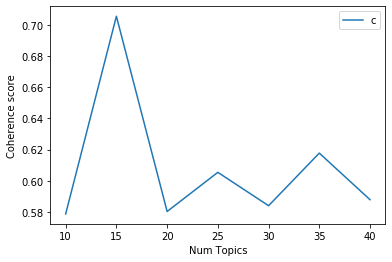

In [52]:
start=10; limit=41; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5787
Num Topics = 15  has Coherence Value of 0.7057
Num Topics = 20  has Coherence Value of 0.5802
Num Topics = 25  has Coherence Value of 0.6054
Num Topics = 30  has Coherence Value of 0.5839
Num Topics = 35  has Coherence Value of 0.6177
Num Topics = 40  has Coherence Value of 0.5878


In [54]:
# Select the model and print the topics
# optimal_model = model_list[4]
# optimal_model =  models.LdaModel.load('optimal_model.model')
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))